In [28]:
import pydicom
import glob, pylab
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")


import os
print(os.listdir("input"))

['stage_1_detailed_class_info.csv', 'stage_1_sample_submission.csv', 'stage_1_test_images', 'stage_1_train_images', 'stage_1_train_labels.csv']


In [29]:
# number of images in datasets
print(len(os.listdir("input/stage_1_test_images")), 'imgs in a test set')
print(len(os.listdir("input/stage_1_train_images")), 'imgs in a train set')

1000 imgs in a test set
25684 imgs in a train set


In [31]:
train_labels = pd.read_csv('input/stage_1_train_labels.csv', index_col='patientId')
train_labels.head()

,x,y,width,height,Target
patientId,,,,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


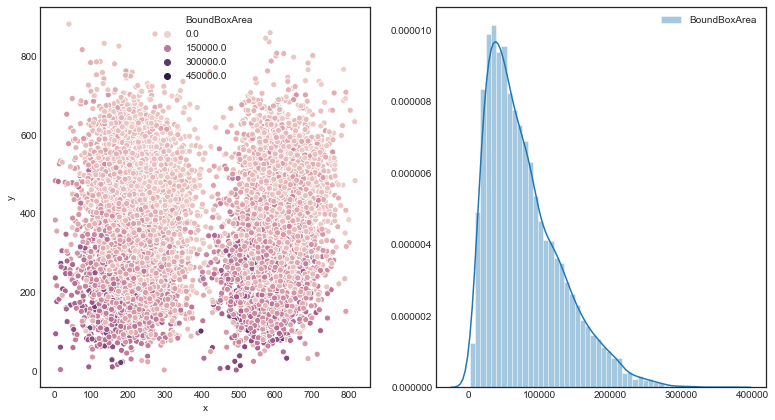

In [32]:
train_labels['BoundBoxArea'] = train_labels.width*train_labels.height
train_labels.BoundBoxArea.fillna(0, inplace=True)
boxes = train_labels[train_labels.BoundBoxArea > 0]

fig, axs = plt.subplots(1, 2, figsize=(13, 7))
sns.scatterplot(x='x', y='y', hue='BoundBoxArea', data=boxes, ax=axs[0])
sns.distplot(boxes.BoundBoxArea.values, ax=axs[1], label='BoundBoxArea')
plt.legend()
plt.show()

In [33]:
train_labels.head()

,x,y,width,height,Target,BoundBoxArea
patientId,,,,,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,0.0
00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,0.0
00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,0.0
003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,0.0
00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,80727.0


In [34]:
#https://www.kaggle.com/peterchang77/exploratory-data-analysis

def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': 'input/stage_1_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

In [35]:
df = pd.read_csv('input/stage_1_train_labels.csv')
parsed = parse_data(df)

In [8]:
parsed['0004cfab-14fd-4e49-80ba-63a80b6bddd6']

{'dicom': 'input/stage_1_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm',
 'label': 0,
 'boxes': []}

In [9]:
data = parsed[train_labels.index.unique()[7]]
d = pydicom.read_file(data['dicom'])
im = d.pixel_array
data

{'dicom': 'input/stage_1_train_images/00704310-78a8-4b38-8475-49f4573b2dbb.dcm',
 'label': 1,
 'boxes': [[577.0, 323.0, 104.0, 160.0], [575.0, 695.0, 137.0, 162.0]]}

In [27]:
data

{'dicom': 'input/stage_1_train_images/fffec09e-8a4a-48b1-b33e-ab4890ccd136.dcm',
 'label': 0,
 'boxes': []}

Data loaded. 

# Things I can try: 

 - Try a simple classifier on target values. Make it flow from directory. 
 - Yolo3 on bounding boxes
 - Potentially use Unet model to segment the lungs and than run Yolo. 
        (https://colab.research.google.com/github/mdai/ml-lessons/blob/master/lesson2-lung-xrays-segmentation.ipynb)
 - ??

In [10]:
from keras.applications import vgg16
from keras.preprocessing.image import ImageDataGenerator
import cv2
import PIL
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


In [11]:
INPUT_SIZE = 224
N = len(train_labels.index.unique())

In [12]:
imgs = np.zeros((N,INPUT_SIZE,INPUT_SIZE,3))

In [13]:
for i in range(N):
    data = parsed[train_labels.index.unique()[i]]
    d = pydicom.read_file(data['dicom'])
    im =  cv2.resize(im,(INPUT_SIZE, INPUT_SIZE))
    imgs[i,:,:,0] = im
    imgs[i,:,:,1] = im
    imgs[i,:,:,2] = im
    if i%1000 ==0:
        print(i)    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


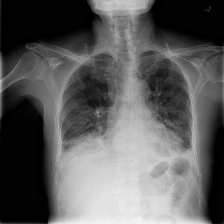

In [14]:
im = PIL.Image.fromarray(imgs[N-1].astype('uint8'),'RGB')
im

In [15]:
y = np.zeros((N,))
for i in range(N):
    data = parsed[train_labels.index.unique()[i]]
    y[i] = data['label']
    if i%1000 ==0:
        print(i)
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


In [16]:
n= (0.8*N)
n = int(n)
#Xtr = imgs[0:n]
#Xv = imgs[n:]
ytr = y[:n]
yv = y[n:]

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input)
generator = train_datagen.flow(imgs[0:n],   ytr, shuffle=False, batch_size=8)


In [24]:
model = vgg16.VGG16(weights='imagenet',include_top=False, input_shape=(INPUT_SIZE,INPUT_SIZE,3), pooling='avg')

In [20]:
#features = model.predict_generator(generator,verbose=1)
#np.save('vggfeatures.npy',features)
features = np.load('vggfeatures.npy')
print(features.shape)

(20547, 512)


In [21]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
logreg.fit(features,ytr)
logreg.score(features,ytr)

0.760743660875067

In [26]:
val_datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input)
val_generator = val_datagen.flow(imgs[n:],  yv, shuffle=False, batch_size=8)
val_features = model.predict_generator(val_generator,verbose=1)
np.save('vggfeatures_val.npy',val_features)
valid_preds = logreg.predict(val_features)  
print('Validation Accuracy {}'.format(accuracy_score(yv, valid_preds)))

643/643 [==============================] - 6647s 10s/step
Validation Accuracy 0.8553630523651937
